# Intoduction
###### By Yevhen Fishchuk

In this work I'll:
<br />
1) Get charts data by three countries with Spotify API 
<br />
2) Clean and prepare data for analysis
<br />
3) Find similarities between charts
<br />
4) Try to answer question "What parameters of song should be for it to be popular"

Since these charts change with time, i created <a href="https://github.com/ekotas/Spotify-trends-analysis-">GitHub project</a> to save data I used

In [1]:
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from bs4 import BeautifulSoup
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.linear_model import LinearRegression

In [2]:
# Change settings of how columns are showing to look at all columns
pd.set_option('display.max_columns', None)
# Change size of plots make them more readible
plt.rcParams["figure.figsize"] = (7, 3)

In [3]:
# Create credentials to use Spotify API
cid = '###'
secret = '###'

In [4]:
# Connect to Spotify API
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [5]:
# Insert charts we are interested in
chart_urls = ['https://open.spotify.com/playlist/37i9dQZEVXbKkidEfWYRuD?si=2447111c11214555', # Ukraine
              'https://open.spotify.com/playlist/37i9dQZEVXbNfM2w2mq1B8?si=03f93f5bd356427a', # Bulgaria
              'https://open.spotify.com/playlist/37i9dQZEVXbLnolsZ8PSNw?si=710a3739806149bd'] # UK

In [6]:
# Create function to retrieve all charts
def get_charts_info(chart_urls):
    df_list = []
    for chart_url in chart_urls:
        
        chart_info = sp.playlist(chart_url)
        
        playlist_country = chart_info['name'].split()[-1]
        df = pd.DataFrame(columns=['Track name', 'Artist', 'Popularity', 'Track URL', 'id', 'Playlist country'])
        for track in chart_info['tracks']['items']:
            df.loc[len(df)] = [track['track']['name'], track['track']['artists'][0]['name'],
                               track['track']['popularity'], track['track']['external_urls']['spotify'], 
                               track['track']['id'], playlist_country]
            
        tracks_url = list(df['Track URL'])
        tracks_features = sp.audio_features(tracks_url)
        tracks_features = pd.DataFrame(tracks_features)
        df = df.merge(tracks_features, on = 'id')
        df_list.append(df)
        df.to_csv(playlist_country + '.csv')
    return df_list

In [7]:
# Use created function
df_list = get_charts_info(chart_urls)

In [8]:
# Save column names for futher usage
column_names = df_list[0].columns
column_names

Index(['Track name', 'Artist', 'Popularity', 'Track URL', 'id',
       'Playlist country', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'type', 'uri', 'track_href', 'analysis_url',
       'duration_ms', 'time_signature'],
      dtype='object')

In [9]:
# Keep only tracks that in every chart
df_common_tracks = df_list[0].merge(df_list[1], on = ['Track name', 'Artist']). \
            merge(df_list[2], on = ['Track name', 'Artist'])
# Keep only one column of entity
df_common_tracks = df_common_tracks.iloc[: , :23]
# Make column names easier to read
df_common_tracks.columns = column_names

In [10]:
df_common_tracks

,Track name,Artist,Popularity,Track URL,id,Playlist country,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature
0,Another Love,Tom Odell,56,https://open.spotify.com/track/7jtQIBanIiJOMS6...,7jtQIBanIiJOMS6RyCx6jZ,Ukraine,0.442,0.538,4,-8.550,0,0.0451,0.717,0.000029,0.0900,0.139,122.758,audio_features,spotify:track:7jtQIBanIiJOMS6RyCx6jZ,https://api.spotify.com/v1/tracks/7jtQIBanIiJO...,https://api.spotify.com/v1/audio-analysis/7jtQ...,244360,4
1,Running Up That Hill (A Deal With God),Kate Bush,94,https://open.spotify.com/track/75FEaRjZTKLhTrF...,75FEaRjZTKLhTrFGsfMUXR,Ukraine,0.629,0.547,10,-13.123,0,0.0550,0.720,0.003140,0.0604,0.197,108.375,audio_features,spotify:track:75FEaRjZTKLhTrFGsfMUXR,https://api.spotify.com/v1/tracks/75FEaRjZTKLh...,https://api.spotify.com/v1/audio-analysis/75FE...,298933,4


# Tracks analysis
We see that in all of the charts there is only 2 songs. Let's try to understand what is so special about these songs:
<br />
&emsp; 1) <b>Another Love</b> by Tom Odell is song of 2013 year. Even that this song not new - it became popular because of TikTok and it became the unofficial anthem for Ukraine in TikTok.
<br />
&emsp; 2) <b>Running Up That Hill (A Deal With God)</b> by Kate Bush is already 37 y.o. so it's very is it so popular now. But there very easy answer for this: It is main soundtrack of one of the most popular TV Shows of all time on Netflix, "Stranger Things".

# Next steps
&emsp; It is not quantitive and precise data therefore it's not very reliable so let's get into numbers. Also, making analysis based on only this tracks is not really right, so let's watch on most popular tracks around the world right now. Also I will need genre of songs, but Spotify API have only information about genres, related to artists and it's not precise information about tracks so I'll use Last FM API.

In [11]:
# Write credentials for Last FM API
LAST_FM_API_KEY = '###'
LAST_FM_API_SECRET = '###'
username = '###'

In [12]:
# Dictionary for GET request from Last FM
headers = {
    'user-agent': username
}

In [13]:
# Get genre for all tracks
for index, row in df_common_tracks.iterrows():
    payload = {
        'api_key': LAST_FM_API_KEY,
        'method': 'track.getInfo',
        'format': 'json',
        'artist': row['Artist'],
        'track': row['Track name']
    }
    r = requests.get('https://ws.audioscrobbler.com/2.0/', headers=headers, params=payload)
    df_common_tracks.loc[index, ['Genre']] = r.json()['track']['toptags']['tag'][0]['name']

In [14]:
df_common_tracks

,Track name,Artist,Popularity,Track URL,id,Playlist country,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,Genre
0,Another Love,Tom Odell,56,https://open.spotify.com/track/7jtQIBanIiJOMS6...,7jtQIBanIiJOMS6RyCx6jZ,Ukraine,0.442,0.538,4,-8.550,0,0.0451,0.717,0.000029,0.0900,0.139,122.758,audio_features,spotify:track:7jtQIBanIiJOMS6RyCx6jZ,https://api.spotify.com/v1/tracks/7jtQIBanIiJO...,https://api.spotify.com/v1/audio-analysis/7jtQ...,244360,4,indie
1,Running Up That Hill (A Deal With God),Kate Bush,94,https://open.spotify.com/track/75FEaRjZTKLhTrF...,75FEaRjZTKLhTrFGsfMUXR,Ukraine,0.629,0.547,10,-13.123,0,0.0550,0.720,0.003140,0.0604,0.197,108.375,audio_features,spotify:track:75FEaRjZTKLhTrFGsfMUXR,https://api.spotify.com/v1/tracks/75FEaRjZTKLh...,https://api.spotify.com/v1/audio-analysis/75FE...,298933,4,80s


In [15]:
# Get global chart
global_chart_info = sp.playlist('https://open.spotify.com/playlist/37i9dQZEVXbMDoHDwVN2tF?si=de7ff015880d493f')

In [16]:
global_chart_df = pd.DataFrame(columns=['Track name', 'Artist', 'Popularity', 'Track URL', 'id', 'Playlist country'])
global_chart_df

,Track name,Artist,Popularity,Track URL,id,Playlist country


In [17]:
# Turn JSON into DataFrame
for track in global_chart_info['tracks']['items']:
            global_chart_df.loc[len(global_chart_df)] = [track['track']['name'], track['track']['artists'][0]['name'],
                               track['track']['popularity'], track['track']['external_urls']['spotify'], 
                               track['track']['id'], global_chart_info['name'].split()[-1]]
global_chart_df.head()

,Track name,Artist,Popularity,Track URL,id,Playlist country
0,"Quevedo: Bzrp Music Sessions, Vol. 52",Bizarrap,100,https://open.spotify.com/track/2tTmW7RDtMQtBk7...,2tTmW7RDtMQtBk7m2rYeSw,Global
1,As It Was,Harry Styles,93,https://open.spotify.com/track/4Dvkj6JhhA12EX0...,4Dvkj6JhhA12EX05fT7y2e,Global
2,Pink Venom,BLACKPINK,88,https://open.spotify.com/track/0skYUMpS0Acbpjc...,0skYUMpS0AcbpjcGsAbRGj,Global
3,Me Porto Bonito,Bad Bunny,99,https://open.spotify.com/track/6Sq7ltF9Qa7SNFB...,6Sq7ltF9Qa7SNFBsV5Cogx,Global
4,Tití Me Preguntó,Bad Bunny,97,https://open.spotify.com/track/1IHWl5LamUGEuP4...,1IHWl5LamUGEuP4ozKQSXZ,Global


In [18]:
# Add to DataFrame info about tracks` features
tracks_url = list(global_chart_df['Track URL'])
tracks_features = sp.audio_features(tracks_url)
tracks_features = pd.DataFrame(tracks_features)
global_chart_df = global_chart_df.merge(tracks_features, on = 'id')

In [19]:
global_chart_df.head()

,Track name,Artist,Popularity,Track URL,id,Playlist country,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature
0,"Quevedo: Bzrp Music Sessions, Vol. 52",Bizarrap,100,https://open.spotify.com/track/2tTmW7RDtMQtBk7...,2tTmW7RDtMQtBk7m2rYeSw,Global,0.621,0.782,2,-5.548,1,0.0440,0.0125,0.033000,0.2300,0.550,128.033,audio_features,spotify:track:2tTmW7RDtMQtBk7m2rYeSw,https://api.spotify.com/v1/tracks/2tTmW7RDtMQt...,https://api.spotify.com/v1/audio-analysis/2tTm...,198938,4
1,As It Was,Harry Styles,93,https://open.spotify.com/track/4Dvkj6JhhA12EX0...,4Dvkj6JhhA12EX05fT7y2e,Global,0.520,0.731,6,-5.338,0,0.0557,0.3420,0.001010,0.3110,0.662,173.930,audio_features,spotify:track:4Dvkj6JhhA12EX05fT7y2e,https://api.spotify.com/v1/tracks/4Dvkj6JhhA12...,https://api.spotify.com/v1/audio-analysis/4Dvk...,167303,4
2,Pink Venom,BLACKPINK,88,https://open.spotify.com/track/0skYUMpS0Acbpjc...,0skYUMpS0AcbpjcGsAbRGj,Global,0.798,0.697,0,-7.139,1,0.0891,0.0202,0.000000,0.2590,0.745,90.031,audio_features,spotify:track:0skYUMpS0AcbpjcGsAbRGj,https://api.spotify.com/v1/tracks/0skYUMpS0Acb...,https://api.spotify.com/v1/audio-analysis/0skY...,186964,4
3,Me Porto Bonito,Bad Bunny,99,https://open.spotify.com/track/6Sq7ltF9Qa7SNFB...,6Sq7ltF9Qa7SNFBsV5Cogx,Global,0.911,0.712,1,-5.105,0,0.0817,0.0901,0.000027,0.0933,0.425,92.005,audio_features,spotify:track:6Sq7ltF9Qa7SNFBsV5Cogx,https://api.spotify.com/v1/tracks/6Sq7ltF9Qa7S...,https://api.spotify.com/v1/audio-analysis/6Sq7...,178567,4
4,Tití Me Preguntó,Bad Bunny,97,https://open.spotify.com/track/1IHWl5LamUGEuP4...,1IHWl5LamUGEuP4ozKQSXZ,Global,0.650,0.715,5,-5.198,0,0.2530,0.0993,0.000291,0.1260,0.187,106.672,audio_features,spotify:track:1IHWl5LamUGEuP4ozKQSXZ,https://api.spotify.com/v1/tracks/1IHWl5LamUGE...,https://api.spotify.com/v1/audio-analysis/1IHW...,243717,4


In [20]:
# Get genre for all tracks
for index, row in global_chart_df.iterrows():
    payload = {
        'api_key': LAST_FM_API_KEY,
        'method': 'track.getInfo',
        'format': 'json',
        'artist': row['Artist'],
        'track': row['Track name']
    }
    r = requests.get('https://ws.audioscrobbler.com/2.0/', headers=headers, params=payload)
    try:
        global_chart_df.loc[index, ['Genre']] = r.json()['track']['toptags']['tag'][0]['name']
    except IndexError:
        global_chart_df.loc[index, ['Genre']] = 'API Exception'
global_chart_df.head()

,Track name,Artist,Popularity,Track URL,id,Playlist country,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,Genre
0,"Quevedo: Bzrp Music Sessions, Vol. 52",Bizarrap,100,https://open.spotify.com/track/2tTmW7RDtMQtBk7...,2tTmW7RDtMQtBk7m2rYeSw,Global,0.621,0.782,2,-5.548,1,0.0440,0.0125,0.033000,0.2300,0.550,128.033,audio_features,spotify:track:2tTmW7RDtMQtBk7m2rYeSw,https://api.spotify.com/v1/tracks/2tTmW7RDtMQt...,https://api.spotify.com/v1/audio-analysis/2tTm...,198938,4,argentina
1,As It Was,Harry Styles,93,https://open.spotify.com/track/4Dvkj6JhhA12EX0...,4Dvkj6JhhA12EX05fT7y2e,Global,0.520,0.731,6,-5.338,0,0.0557,0.3420,0.001010,0.3110,0.662,173.930,audio_features,spotify:track:4Dvkj6JhhA12EX05fT7y2e,https://api.spotify.com/v1/tracks/4Dvkj6JhhA12...,https://api.spotify.com/v1/audio-analysis/4Dvk...,167303,4,pop
2,Pink Venom,BLACKPINK,88,https://open.spotify.com/track/0skYUMpS0Acbpjc...,0skYUMpS0AcbpjcGsAbRGj,Global,0.798,0.697,0,-7.139,1,0.0891,0.0202,0.000000,0.2590,0.745,90.031,audio_features,spotify:track:0skYUMpS0AcbpjcGsAbRGj,https://api.spotify.com/v1/tracks/0skYUMpS0Acb...,https://api.spotify.com/v1/audio-analysis/0skY...,186964,4,k-pop
3,Me Porto Bonito,Bad Bunny,99,https://open.spotify.com/track/6Sq7ltF9Qa7SNFB...,6Sq7ltF9Qa7SNFBsV5Cogx,Global,0.911,0.712,1,-5.105,0,0.0817,0.0901,0.000027,0.0933,0.425,92.005,audio_features,spotify:track:6Sq7ltF9Qa7SNFBsV5Cogx,https://api.spotify.com/v1/tracks/6Sq7ltF9Qa7S...,https://api.spotify.com/v1/audio-analysis/6Sq7...,178567,4,latin
4,Tití Me Preguntó,Bad Bunny,97,https://open.spotify.com/track/1IHWl5LamUGEuP4...,1IHWl5LamUGEuP4ozKQSXZ,Global,0.650,0.715,5,-5.198,0,0.2530,0.0993,0.000291,0.1260,0.187,106.672,audio_features,spotify:track:1IHWl5LamUGEuP4ozKQSXZ,https://api.spotify.com/v1/tracks/1IHWl5LamUGE...,https://api.spotify.com/v1/audio-analysis/1IHW...,243717,4,latin


In [21]:
global_chart_df.to_csv('Global chart.csv')

In [22]:
global_chart_df['Genre'].unique()

array(['argentina', 'pop', 'k-pop', 'latin', 'merengue', 'spanish', '80s',
       'indie', 'Ballad', 'Reggaeton', 'Chris Brown', 'API Exception',
       'Hip-Hop', 'Eurovision', 'pop rap', 'Disco', 'soty',
       'a subtle use of vocal harmony', 'House', 'rnb', 'Camila Cabello',
       'hip hop', 'bts', 'synthwave', '2020s', 'Soundtrack', 'rock',
       'electronic'], dtype=object)

###### There is too much genres to visualize it so I'll group them
I will group subgenres into bigger genres and also there is artist names, so I'll change them into genre that they represent.

In [23]:
# Create mapping dictionary to perform changes
genres_mapping = {
    'pop' : 'Pop',
    'k-pop': 'Pop',
    'rnb': 'Pop',
    'bts': 'Pop',
    'indie': 'Pop',
    'Chris Brown': 'Pop',
    'Camila Cabello': 'Pop',
    'a subtle use of vocal harmony': 'Pop',
    'merengue': 'Hispanic american dance music',
    'Reggaeton': 'Hispanic american dance music',
    'argentina': 'Hispanic american dance music',
    'latin': 'Hispanic american dance music',
    'spanish': 'Hispanic american dance music',
    'pop rap': 'Hip-Hop',
    'hip hop': 'Hip-Hop',
    'electronic': 'Electronic',
    'House': 'Electronic',
    'synthwave': 'Electronic',
    'rock': 'Rock',
    'Ballad': 'Rock',
    'Soundtrack': 'Undefined',
    'Eurovision': 'Undefined',
    'soty': 'Undefined',
    '80s': 'Undefined',
    '2020s': 'Undefined'
}
global_chart_df['Genre'] = global_chart_df['Genre'].map(genres_mapping).fillna(global_chart_df['Genre'])

# For visualizing purposes I'll change names of genres to numbers
genres_code = {
    'Pop': 1,
    'Hispanic american dance music': 2,
    'Hip-Hop': 3,
    'Electronic': 4,
    'Rock': 5,
    'Undefined': 6,
    'API Exception': 7,
    'Disco': 8
}
global_chart_df['Genre code'] = global_chart_df['Genre'].map(genres_code).fillna(global_chart_df['Genre'])
global_chart_df['Genre code'].unique()

array([2, 1, 6, 5, 7, 3, 8, 4], dtype=int64)

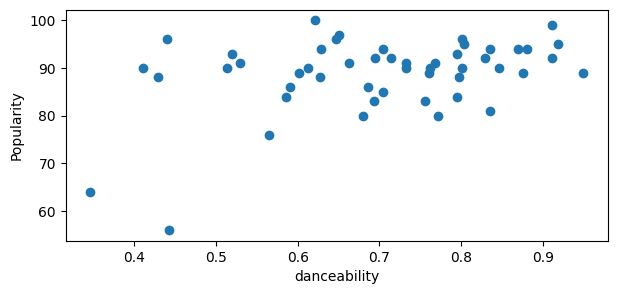

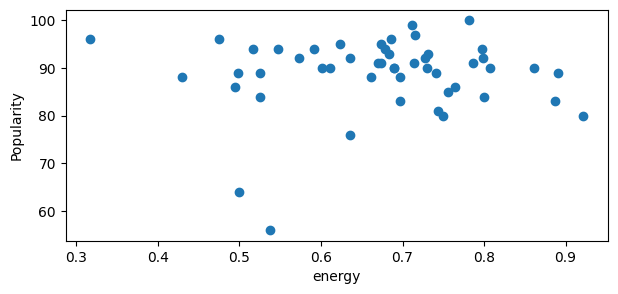

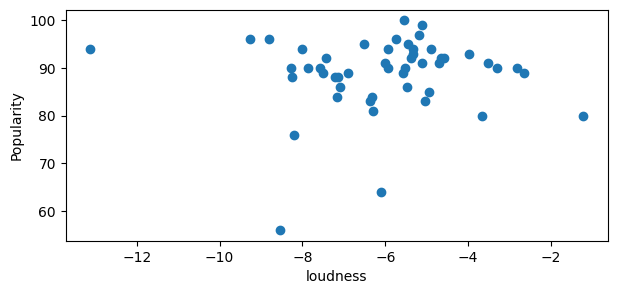

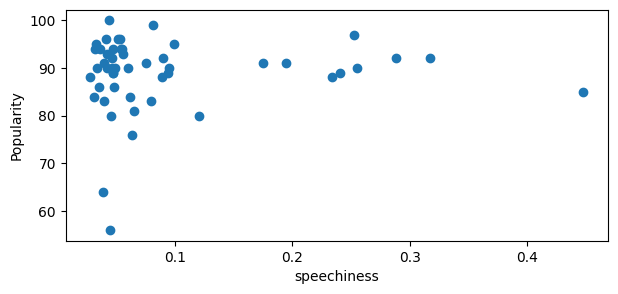

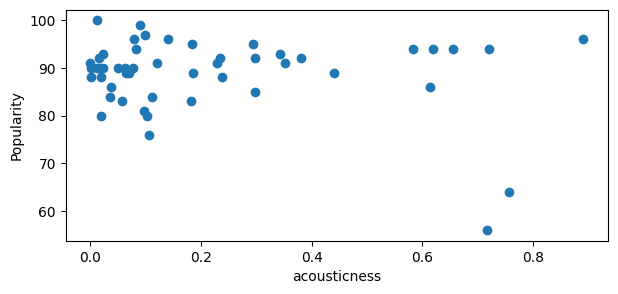

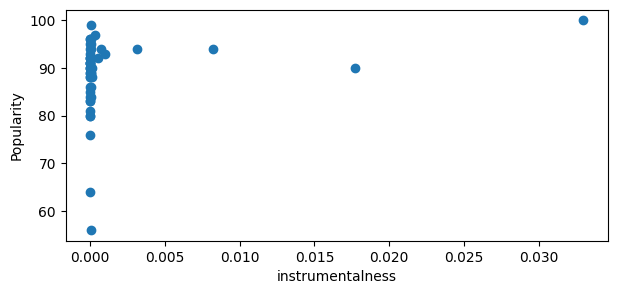

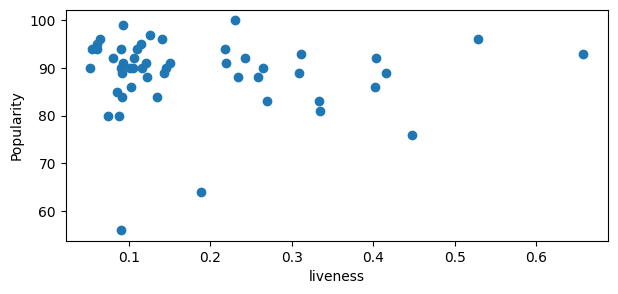

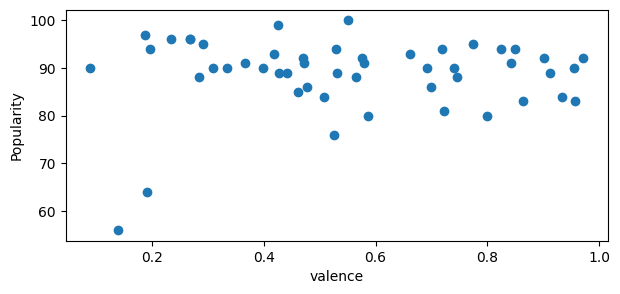

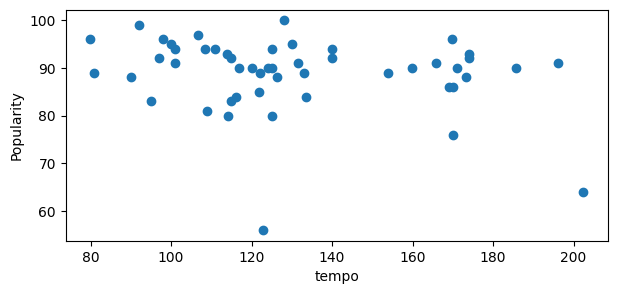

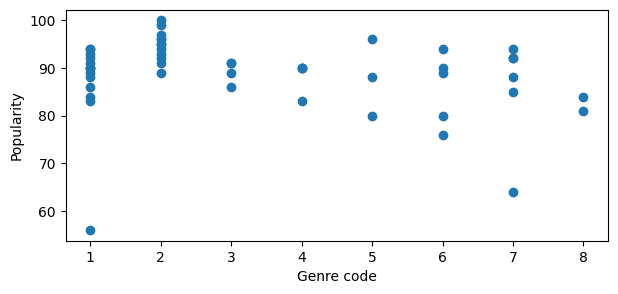

In [24]:
# Create scatter plots of features against popularity
features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence',
           'tempo', 'Genre code']
for column in features:
    plt.scatter(global_chart_df[column], global_chart_df['Popularity'])
    plt.xlabel(column)
    plt.ylabel('Popularity')
    plt.show()

Looking at visualization it is not obvious if there is any correlation and what is it, but for such features as:
speechiness, acousticness, instrumentalness there is very interesting thing: almost every song have similar values for each of this features. <br />
To understand correlation I'll calucalte Pearson correlation coefficient

In [25]:
corr_matrix = global_chart_df.corr()
corr_matrix

,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Genre code
Popularity,1.000000,0.386957,0.046674,0.047941,0.038448,-0.025593,0.072068,-0.191679,0.225911,-0.024028,0.066843,-0.219181,-0.015615,0.161709,-0.236189
danceability,0.386957,1.000000,0.199278,-0.000569,0.190571,-0.016813,0.149905,-0.170687,-0.083534,0.024827,0.567322,-0.609073,-0.274669,0.369306,-0.065820
energy,0.046674,0.199278,1.000000,-0.223154,0.729239,0.008627,0.068269,-0.606635,0.140527,0.111164,0.412444,-0.119340,-0.091384,0.133208,-0.053310
key,0.047941,-0.000569,-0.223154,1.000000,-0.105437,-0.175152,-0.151894,0.206262,-0.019044,0.071067,-0.180114,0.003136,0.229359,-0.105518,-0.071312
loudness,0.038448,0.190571,0.729239,-0.105437,1.000000,0.137499,0.160354,-0.400411,0.070929,0.116841,0.349487,-0.016635,-0.238020,0.070949,-0.239161
mode,-0.025593,-0.016813,0.008627,-0.175152,0.137499,1.000000,0.114412,0.059319,0.157427,-0.047656,0.295536,0.149209,-0.353274,-0.018579,0.128551
speechiness,0.072068,0.149905,0.068269,-0.151894,0.160354,0.114412,1.000000,-0.068615,-0.135710,-0.077156,0.123128,0.123152,-0.339710,-0.051011,0.256920
acousticness,-0.191679,-0.170687,-0.606635,0.206262,-0.400411,0.059319,-0.068615,1.000000,-0.074519,-0.096877,-0.129743,0.111610,0.073536,-0.292775,0.056776
instrumentalness,0.225911,-0.083534,0.140527,-0.019044,0.070929,0.157427,-0.135710,-0.074519,1.000000,-0.031498,-0.062569,-0.051385,0.117297,0.047637,-0.084667
liveness,-0.024028,0.024827,0.111164,0.071067,0.116841,-0.047656,-0.077156,-0.096877,-0.031498,1.000000,0.151065,0.031956,0.072843,0.072953,0.035324


<AxesSubplot:>

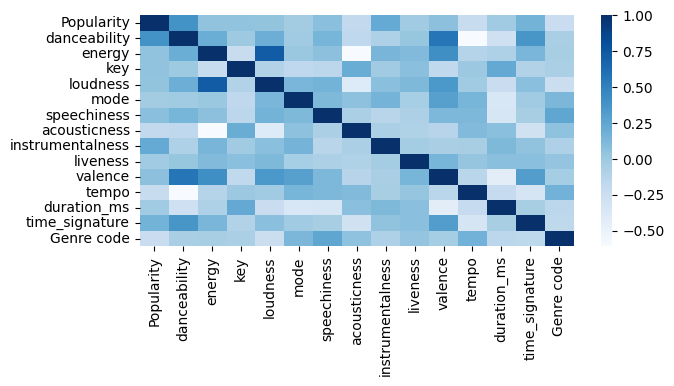

In [26]:
sb.heatmap(corr_matrix, cmap='Blues')

Most of features (<font color='ED7171'>energy, loudness, mode, speechiness, liveness, valence, duration_ms</font>) have small correlation that we can assume they don't make any difference. Let's suppose that <i><font color='ED7171'>danceability, acousticness, instrumentalness, tempo</font></i> should be features that influence popularity of song. Now I'll calculate coefficients to predict popularity.

In [27]:
# For linear regression to perform better it's good to normalize data
global_chart_df['tempo'] = (global_chart_df['tempo'] - global_chart_df['tempo'].min()) / \
                            (global_chart_df['tempo'].max() - global_chart_df['tempo'].min())

In [28]:
# Create target and variables DataFrame to perform LinearRegression
X = global_chart_df[['danceability', 'acousticness', 'instrumentalness', 'tempo']]
y = global_chart_df['Popularity']

# LinearRegression from sklearn
reg = LinearRegression()
reg.fit(X, y)

LinearRegression()

In [29]:
reg.coef_

array([ 23.10600187,  -3.46057181, 376.78966886,   2.14765426])

I calculated coefficients of linear regression and will use them to try to predict popularity of common songs for charts

In [30]:
# If we normalized initial data, we need to normlize test data
df_common_tracks['tempo'] = (df_common_tracks['tempo'] - df_common_tracks['tempo'].min()) / \
                            (df_common_tracks['tempo'].max() - df_common_tracks['tempo'].min())

In [31]:
# Predict popularity. I could use sklearn predict(), but I chose to calculate "by hand"
for _, row in df_common_tracks.iterrows():
    predicted_popularity = reg.intercept_ + reg.coef_[0] * row['danceability'] + reg.coef_[1] * row['acousticness'] + \
                           reg.coef_[2] * row['instrumentalness'] + reg.coef_[3] * row['tempo']
    print('For track\033[1m', row['Track name'], '\033[0mpredicted popularity is:', round(predicted_popularity, 2))

For track Another Love predicted popularity is: 81.86
For track Running Up That Hill (A Deal With God) predicted popularity is: 85.2


We see that predictions pretty far from actual values and that is not good if we had a task to predict popularity of song using machine learning tools, but we also can see that these values pretty high so it is possible for songs with this values of popularity be popular around the world.

If I had an objective to create predictive model for song popularity I could have:
<br />
1) Retrieved more data for creating prediction model, because only 50 songs is really-really low quantity
<br />
2) Test another models, or even neural network
<br />
3) Perform learning by each genre
<br />
4) Add analysis of lyrics

# Project outcome
### What I did
During this project I did this:
<br />
1) Retrieved data using 2 different API of music sites <br />
2) Cleaned data <br />
3) Found common tracks for 3 charts from different countries <br />
4) Found information about these songs on the internet to get basic understanding of them <br />
5) To get understanding of popularity of songs in terms of numbers - I performed analysis of currently top songs around the world, found most important features, implemented linear regression and tried to "predict" popularity of given songs.

### Results
With this analysis i found out that 3 countries from 1 continent have big differences in musical preferences because only 2 songs were common for all of them. Song popularity might depend on numerous quantitive features, but only 4 of them were making the real difference. These features are: <i>danceability, acousticness, instrumentalness, tempo</i>. But not only quantitive features are important, generally saying marketing is one of the most important things, because we saw that even that track is 37 years old, it became popular because it has been promoted in TV series, or another old track has been used widely on the internet lately. Also I'm surprised that loudness is not one of significant features because there are studies that more loudness - more human get pleasure from song, so this would be one of the extension of my work.
### Next possible steps
As I already mentioned there are two possible ways to extended this project, specifically:
<br />
1) Create predictive model
<br />
2) Find out why in this project I got that loudness is not a significant feature

Thanks for your time and goodbye!